This notebook will explore different combinations of the features that were used in submission and save the results/evaluations to compare the different scores.

In [1]:
import os, sys

In [2]:
sys.path.append('../final_system')

In [3]:
import annotation
import base_feature
import made_utils

from nltk import ngrams as nltk_ngrams
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict

In [4]:
DATADIR = os.path.join(os.path.expanduser('~'), 'Box Sync', 'NLP_Challenge', 'MADE-1.0')
os.path.exists(DATADIR)

True

In [5]:
def normalize_grams(ngram_string):
    """
    Normalizes the values in a string of joined ngrams
    """
    # Substitute numbers
    ngram_string = re.sub('[\d]+|one|two|three|four|five|six|seven|eight|nine|ten', '<NUMBER>', ngram_string)
    return ngram_string



class LexicalFeatureExtractor(base_feature.BaseFeatureExtractor):
    """
    ngram_window - the length of ngrams to include in the vocabulary.
    context_window - the number of ngrams to include before and after the entity.
    """
    def __init__(self, ngram_window=(1, 1), context_window=(2, 2),
                vocab=None, pos_vocab=None, min_vocab_count=5, min_pos_count=5):
        super().__init__()
        self.ngram_window = ngram_window
        if min(ngram_window) < 1 or max(ngram_window) > 3:
            raise NotImplementedError("Ngram Window must be between one and 3")
        self.context_window = context_window
        self.min_vocab_count = min_vocab_count
        self.min_pos_count = min_pos_count

        # Set vocab and POS vocab
        self._unfiltered_vocab = vocab # Contains unigrams-trigrams, no count threshold
        self._unfiltered_pos_vocab = pos_vocab

        self.vocab = self.create_vocab(vocab, min_vocab_count, self.ngram_window) # Only contains ngrams defined by context_window
        #print(self.vocab); exit()
        self.pos_vocab =  self.create_vocab(pos_vocab, min_pos_count, self.ngram_window)
        #self.tokens = [gram for (gram, idx) in self.vocab.items() if len(gram.split()) == 1] # Only unigrams
        self.pos = {} # Will eventually contain mapping for POS tags

        # pyConText tools
        #self.modifiers = itemData.instantiateFromCSVtoitemData("https://raw.githubusercontent.com/chapmanbe/pyConTextNLP/master/KB/lexical_kb_05042016.tsv")
        #self.targets = itemData.instantiateFromCSVtoitemData("https://raw.githubusercontent.com/abchapman93/MADE_relations/master/feature_extraction/targets.tsv?token=AUOYx9rYHO6A5fiZS3mB9e_3DP83Uws8ks5aownVwA%3D%3D")


        #self.all_features_values = self.create_base_features()



    def create_base_features(self):
        """
        Enumerates possible feature values from the vocab, as well as an OOV value.
        Any features that are binary should only get one index and are encoded as 0.
        """
        # This will be a dictionary that contains all possible values for each feature
        all_features_values = {
            'same_sentence': 0,
            'num_tokens_between': 0,
            'grams_between': ['OOV'] + list(self.vocab),
            'grams_before': ['OOV'] + list(self.vocab),
            'grams_after': ['OOV'] + list(self.vocab),
            'pos_grams_between': ['OOV'] + list(self.pos_vocab),
            #'pos_grams_before': ['OOV'] + list(self.pos_vocab),
            #'pos_grams_after': ['OOV'] + list(self.pos_vocab),
            'first_entity_type': 0,#list(ENTITY_TYPES_MAPPING.values()),
            'second_entity_type': 0,#list(ENTITY_TYPES_MAPPING.values()),

            }
        return all_features_values

    def create_feature_dict(self, relat, doc, entities=True, entities_between=True, surface=True):
        """
        Takes a RelationAnnotation and an AnnotatedDocument.
        Returns the a dictionary containing the defined lexical features.
        """

        lex_features = {}

        if entities:
            lex_features.update(self.get_entity_features(relat, doc))
        if entities_between:
            lex_features.update(self.get_entities_between_features(relat, doc))
        if surface:
            lex_features.update(self.get_surface_features(relat, doc))
        return lex_features
    
    
    def get_entity_features(self, relat, doc):
        features = {}
        
        # The full string of the entities
        anno1, anno2 = relat.get_annotations()
        features['text_in_anno1'] = anno1.text.lower()
        features['text_in_anno2'] = anno2.text.lower()
        features['concat_text'] = anno1.text.lower() + ':' + anno2.text.lower()
        
        # Features for types of the entities
        features['first_entity_type:<{}>'.format(relat.entity_types[0].upper())] = 1
        features['second_entity_type:<{}>'.format(relat.entity_types[1].upper())] = 1
        
        # Feature types for entities, left to right
        sorted_entities = sorted((relat.annotation_1, relat.annotation_2), key=lambda a: a.span[0])
        features['entity_types_concat'] = '<=>'.join(['<{}>'.format(a.type.upper()) for a in sorted_entities])
        return features
    
    
    def get_entities_between_features(self, relat, doc):
       
        features = {}
        # One binary feature for every type of entity between
        entities_between = self.get_entities_between(relat, doc)
        # TODO: Maybe change this to a count
        features.update({
            'entities_between:<{}>'.format(v.type.upper()): 1 for v in entities_between
            })
        features['num_entities_between'] = len(entities_between)

        
        return features
    
    
    
    def get_surface_features(self, relat, doc):        
        
        features = {}
        
        # Same sentence
        features['num_sentences_overlap'] = len(doc.get_sentences_overlap_span(relat.get_span()))
        # Get the number of tokens between
        # NOTE: only unigrams
        
        features['num_tokens_between'] = len(self.get_grams_between(relat, doc, ngram_window=(1, 1)))
        # Get all tokens/POS tags in between
        # Create one feature for each ngram/tag
        features.update({
            'grams_between:<{}>'.format(v): 1 for v in self.get_grams_between(relat, doc)
            })
        features.update({
            'grams_before:<{}>'.format(v): 1 for v in self.get_grams_before(relat, doc)
            })
        features.update({
            'grams_after:<{}>'.format(v): 1 for v in self.get_grams_after(relat, doc)
            })

        features.update({
            'tags_between:<{}>'.format(v): 1 for v in self.get_grams_between(relat, doc, seq='tags')
            })
        features.update({
            'tags_before:<{}>'.format(v): 1 for v in self.get_grams_before(relat, doc, seq='tags')
            })
        features.update({
            'tags_after:<{}>'.format(v): 1 for v in self.get_grams_after(relat, doc, seq='tags')
            })

        # Get features for information about entities/context between
        # Binary feature: Are they in the same sentence?
        features['same_sentence'] = doc.in_same_sentence(relat.get_span())
        return features
        

    def get_grams_between(self, relat, doc, seq='tokens', ngram_window=None):
        """
        Returns the N-grams between the two entities connected in relat.
        Represents it as OOV if it's not in the vocabulary.
        Returns a unique set.
        """

        if seq == 'tokens':
            vocab = self.vocab
        elif seq == 'tags':
            vocab = self.pos_vocab
        else:
            raise ValueError("Must specify seq: {}".format(seq))

        if not ngram_window:
            ngram_window = self.ngram_window

        all_grams = []
        span1, span2 = relat.spans
        # Fixed this: get the start and span of the middle, not of the entire relation
        _, start, end, _ = sorted(span1 +span2)
        tokens_in_span = doc.get_tokens_or_tags_at_span((start, end), seq)
        # NOTE: lower-casing the ngrams, come back to this if you want to encode the casing
        tokens_in_span = [token.lower() for token in tokens_in_span]
        for n in range(ngram_window[0], ngram_window[1] + 1):
            # Now sort the ngrams so that it doesn't matter what order they occur in
            grams = list(nltk_ngrams(tokens_in_span, n))
            grams = self.sort_ngrams(grams)# + [' '.join(sorted(tup)) for tup in list(nltk_ngrams(tokens_in_span, n))]
            all_grams.extend(set(grams))
        all_grams = [self.normalize_grams(x) for x in set(all_grams)]
        all_grams = [x if x in vocab else 'OOV' for x in all_grams]
        return set(all_grams)


    def get_grams_before(self, relat,doc, seq='tokens', ngram_window=None):
        """
        Returns the n-grams before the first entity.
        """
        if seq == 'tokens':
            vocab = self.vocab
        elif seq == 'tags':
            vocab = self.pos_vocab
        if not ngram_window:
            ngram_window = self.ngram_window

        all_grams = []
        offset = relat.span[0]
        tokens_before = doc.get_tokens_or_tags_before_or_after(offset, delta=-1,
            n=self.context_window[0], seq=seq, padding=True)
        tokens_before = [token.lower() for token in tokens_before]
        for n in range(ngram_window[0], ngram_window[1] + 1):
            grams = list(nltk_ngrams(tokens_before, n))
            grams = self.sort_ngrams(grams)# + [' '.join(sorted(tup)) for tup in list(nltk_ngrams(tokens_in_span, n))]
            all_grams.extend(set(grams))
            #grams = grams + [' '.join(sorted(tup)) for tup in list(nltk_ngrams(tokens_before, n))]
        all_grams = [self.normalize_grams(x) for x in set(all_grams)]
        all_grams = [x if x in vocab else 'OOV' for x in all_grams]
        return set(all_grams)

    def get_grams_after(self, relat, doc, seq='tokens', ngram_window=None):
        """
        Returns the n-grams after the final entity.
        """
        if seq == 'tokens':
            vocab = self.vocab
        elif seq == 'tags':
            vocab = self.pos_vocab
        if not ngram_window:
            ngram_window = self.ngram_window

        all_grams = []
        offset = relat.span[1]
        tokens_after = doc.get_tokens_or_tags_before_or_after(offset, delta=1,
                                        n=self.context_window[1], seq=seq)
        tokens_after = [token.lower() for token in tokens_after]
        for n in range(ngram_window[0], ngram_window[1] + 1):
            grams = list(nltk_ngrams(tokens_after, n))
            grams = self.sort_ngrams(grams)# + [' '.join(sorted(tup)) for tup in list(nltk_ngrams(tokens_in_span, n))]
            all_grams.extend(set(grams))
            #grams = grams + [' '.join(sorted(tup)) for tup in list(nltk_ngrams(tokens_after, n))]
        all_grams = [self.normalize_grams(x) for x in set(all_grams)]
        all_grams = [x if x in vocab else 'OOV' for x in all_grams]
        return set(all_grams)

    def sort_ngrams(self, ngrams):
        return [' '.join(sorted(tup)) for tup in ngrams]

    def normalize_grams(self, ngram_string):
        """
        Normalizes the values in a string of joined ngrams
        """
        # Substitute numbers
        return normalize_grams(ngram_string)

    def get_pos_tags(self):
        pass

    def get_entities_between(self, relat, doc):
        """
        Returns a list of entities that occur between entity1 and entity2
        """
        offset, end = relat.get_span()
        overlapping_entities = []
        # Index the entity in doc by span
        offset_to_entity = {entity.span[0]: entity for entity in doc.get_annotations()
                    if entity.id not in (
                        relat.annotation_1.id, relat.annotation_2.id)
                        }

        while offset < end:
            if offset in offset_to_entity:
                overlapping_entities.append(offset_to_entity[offset])
            offset += 1

        return overlapping_entities


    def get_sent_with_anno(self, anno, doc, entity_type):
        """
        Returns the sentence that contains a given annotation.
        Replaces the text of the annotations with a tag <ENTITY-TYPE>
        """
        tokens = []
        # Step back some window
        offset = anno.start_index

        while offset not in doc._sentences:
            offset -= 1
            if offset < 0:
                break
            if offset in doc._tokens:
                tokens.insert(0, doc._tokens[offset].lower())

        # Now add an entity
        tokens.append(entity_type)

        # Now add all the tokens between them
        offset = anno.start_index

        while offset not in doc._sentences:
            if offset > max(doc._tokens.keys()):
                break
            if offset in doc._tokens:
                tokens.append(doc._tokens[offset].lower())
            offset += 1


        return ' '.join(tokens)


    def __repr__(self):
        return "LexicalFeatureExtractor Ngram Window: {} Vocab: {} terms".format(
                self.ngram_window, len(self.vocab))

In [6]:
# reader = made_utils.TextAndBioCParser()
# docs = reader.read_texts_and_xmls(-1) # TODO: Change to -1
# relations = []
# for doc in docs.values():
#     # Add Fake relations for training
#     doc.add_relations(made_utils.pair_annotations_in_doc(doc))
#     relations += doc.get_relations()

In [8]:
import pickle
with open('../final_system/data/vocab.pkl', 'rb') as f:
    vocab, pos_vocab = pickle.load(f)

In [7]:
import pickle
with open('tmp_data/all_training_documents_and_relations.pkl', 'rb') as f:
    docs, relations = pickle.load(f)

In [6]:
relations

['doxorubicin':'infusion', Drug:Route, type=manner/route,
 'doxorubicin':'mantle cell lymphoma', Drug:Indication, type=reason,
 'valacyclovir':'bilateral shingles', Drug:Indication, type=reason,
 'chemotherapy':'mantle cell lymphoma', Drug:Indication, type=reason,
 'bloating':'mild', SSLIF:Severity, type=severity_type,
 'neutropenia medication':'neutropenia', Drug:Indication, type=reason,
 'Valtrex':'500 mg', Drug:Dose, type=do,
 'Valtrex':'3 times daily', Drug:Frequency, type=fr,
 'posaconazole':'200 mg per 5 mL', Drug:Dose, type=do,
 'posaconazole':'3 times daily', Drug:Frequency, type=fr,
 'ciprofloxacin':'500 mg', Drug:Dose, type=do,
 'ciprofloxacin':'daily', Drug:Frequency, type=fr,
 'antiemetics':'p.r.n.', Drug:Frequency, type=fr,
 'analgesics':'p.r.n.', Drug:Frequency, type=fr,
 'hyper-CVAD':'mantle cell lymphoma', Drug:Indication, type=reason,
 'uric acid':'daily', Drug:Frequency, type=fr,
 'uric acid':'prophylaxis', Drug:Indication, type=reason,
 'uric acid':'tumor \nlysis syn

In [10]:
r = relations[7]
doc = docs[r.file_name]
print(r.span)
r

(2918, 2946)


'Valtrex':'3 times daily', Drug:Frequency, type=fr

NameError: name 'docs' is not defined

In [ ]:
# This was probably not the fastest way to do this

feature_extractor = LexicalFeatureExtractor(context_window=(2, 2),
                            ngram_window=(1, 3), vocab=vocab, pos_vocab=pos_vocab,
                            min_vocab_count=20, min_pos_count=20)
feat_dicts = {feature_set_name: [] for feature_set_name in 
              ('entities', 'entities_between', 'surface', 
               'entities+entities_between', 'entities+entities_between+surface')}
for i, r in enumerate(relations):
    if i % 100 == 0:
        print("{}/{}".format(i, len(relations)))
    doc = docs[r.file_name]
    # Single feature sets
    feat_dicts['entities'].append(feature_extractor.create_feature_dict(r, doc, entities=True, entities_between=False, surface=False))
    feat_dicts['entities_between'].append(feature_extractor.create_feature_dict(r, doc, entities=False, entities_between=True, surface=False))
    feat_dicts['surface'].append(feature_extractor.create_feature_dict(r, doc, entities=False, entities_between=False, surface=True))
    
    # Combinations
    feat_dicts['entities+entities_between'].append(feature_extractor.create_feature_dict(r, doc, entities=True, entities_between=True, surface=False))
    feat_dicts['entities+entities_between+surface'].append(feature_extractor.create_feature_dict(r, doc))

In [14]:
with open('tmp_data/feat_dicts', 'wb') as f:
    pickle.dump(feat_dicts, f)

In [13]:
feat_dicts['entities'][7]

{'concat_text': 'valtrex:3 times daily',
 'entity_types_concat': '<DRUG><=><FREQUENCY>',
 'first_entity_type:<DRUG>': 1,
 'second_entity_type:<FREQUENCY>': 1,
 'text_in_anno1': 'valtrex',
 'text_in_anno2': '3 times daily'}

In [19]:
feat_dicts['entities_between'][7]

{'entities_between:<DOSE>': 1, 'num_entities_between': 1}

In [22]:
feat_dicts['surface'][7]

{'grams_after:<<NUMBER>>': 1,
 'grams_after:<OOV>': 1,
 'grams_after:<posaconazole>': 1,
 'grams_before:<OOV>': 1,
 'grams_before:<discharged>': 1,
 'grams_before:<on>': 1,
 'grams_between:<<NUMBER> mg>': 1,
 'grams_between:<<NUMBER>>': 1,
 'grams_between:<mg>': 1,
 'num_sentences_overlap': 1,
 'num_tokens_between': 2,
 'same_sentence': 1,
 'tags_after:<cd jj>': 1,
 'tags_after:<cd>': 1,
 'tags_after:<jj>': 1,
 'tags_before:<in vbn>': 1,
 'tags_before:<in>': 1,
 'tags_before:<vbn>': 1,
 'tags_between:<cd nn>': 1,
 'tags_between:<cd>': 1,
 'tags_between:<nn>': 1}

In [17]:
feat_dicts['entities+entities_between+surface'][7]

{'concat_text': 'valtrex:3 times daily',
 'entities_between:<DOSE>': 1,
 'entity_types_concat': '<DRUG><=><FREQUENCY>',
 'first_entity_type:<DRUG>': 1,
 'grams_after:<<NUMBER>>': 1,
 'grams_after:<OOV>': 1,
 'grams_after:<posaconazole>': 1,
 'grams_before:<OOV>': 1,
 'grams_before:<discharged>': 1,
 'grams_before:<on>': 1,
 'grams_between:<<NUMBER> mg>': 1,
 'grams_between:<<NUMBER>>': 1,
 'grams_between:<mg>': 1,
 'num_entities_between': 1,
 'num_sentences_overlap': 1,
 'num_tokens_between': 2,
 'same_sentence': 1,
 'second_entity_type:<FREQUENCY>': 1,
 'tags_after:<cd jj>': 1,
 'tags_after:<cd>': 1,
 'tags_after:<jj>': 1,
 'tags_before:<in vbn>': 1,
 'tags_before:<in>': 1,
 'tags_before:<vbn>': 1,
 'tags_between:<cd nn>': 1,
 'tags_between:<cd>': 1,
 'tags_between:<nn>': 1,
 'text_in_anno1': 'valtrex',
 'text_in_anno2': '3 times daily'}

In [25]:
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer(sparse=True, sort=True)
# TODO: Freeze the 1000 features that we use


In [26]:
y_full = [r.type for r in relations]
y_bin = ['any' if y_ != 'none' else y_ for y_ in y_full]
y_dict = {'bin': y_bin,
    'full': y_full}
X_dict = {feature_set_name: {'bin': None, 'full': None} for feature_set_name in feat_dicts.keys()}
X_dict

{'entities': {'bin': None, 'full': None},
 'entities+entities_between': {'bin': None, 'full': None},
 'entities+entities_between+surface': {'bin': None, 'full': None},
 'entities_between': {'bin': None, 'full': None},
 'surface': {'bin': None, 'full': None}}

In [28]:
for feature_set_name, features in feat_dicts.items():
    print(feature_set_name)
    k = 1000
    vectorizer = DictVectorizer(sparse=True, sort=True)
    X_vector = vectorizer.fit_transform(features)
    binary_feature_selector = base_feature.MyFeatureSelector(vectorizer, k=k)
    full_feature_selector = base_feature.MyFeatureSelector(vectorizer, k=k)
    try:
        X_bin = binary_feature_selector.fit_transform(X_vector, y_dict['bin'])
    except ValueError: # Not enough features
        vectorizer = DictVectorizer(sparse=True, sort=True)
        X_vector = vectorizer.fit_transform(features)
        k = 'all'
        binary_feature_selector = base_feature.MyFeatureSelector(vectorizer, k=k)
        full_feature_selector = base_feature.MyFeatureSelector(vectorizer, k=k)
    binary_feature_selector = base_feature.MyFeatureSelector(vectorizer, k=k)
    full_feature_selector = base_feature.MyFeatureSelector(vectorizer, k=k)
    vectorizer = DictVectorizer(sparse=True, sort=True)
    X_full = full_feature_selector.fit_transform(X_vector, y_dict['full']) 
    X_dict[feature_set_name]['bin'] = X_bin
    X_dict[feature_set_name]['full'] = X_full

entities
entities_between
surface
entities+entities_between
entities+entities_between+surface


In [29]:
with open('tmp_data/X_dict.pkl', 'wb') as f:
    pickle.dump(X_dict, f)

In [ ]:
with open('tmp_data/X_dict.pkl', 'rb') as f:

In [30]:
X_dict

{'entities': {'bin': <138990x1000 sparse matrix of type '<class 'numpy.float64'>'
  	with 597315 stored elements in Compressed Sparse Row format>,
  'full': <138990x1000 sparse matrix of type '<class 'numpy.float64'>'
  	with 574900 stored elements in Compressed Sparse Row format>},
 'entities+entities_between': {'bin': <138990x1000 sparse matrix of type '<class 'numpy.float64'>'
  	with 1083144 stored elements in Compressed Sparse Row format>,
  'full': <138990x1000 sparse matrix of type '<class 'numpy.float64'>'
  	with 1065331 stored elements in Compressed Sparse Row format>},
 'entities+entities_between+surface': {'bin': <138990x1000 sparse matrix of type '<class 'numpy.float64'>'
  	with 9856632 stored elements in Compressed Sparse Row format>,
  'full': <138990x1000 sparse matrix of type '<class 'numpy.float64'>'
  	with 9964843 stored elements in Compressed Sparse Row format>},
 'entities_between': {'bin': <138990x1000 sparse matrix of type '<class 'numpy.float64'>'
  	with 5973

In [31]:
# Now we can train and evaluate each set
def train_eval_cross_val(X, y):
    """
    Trains and validates a model using cross-validation.
    """
    clf = RandomForestClassifier(max_depth = None,
                            max_features = None,
                            min_samples_leaf = 2,
                            min_samples_split = 2,
                            n_estimators = 10,
                            n_jobs = 3)

    pred = cross_val_predict(clf, X, y)
    score = classification_report(y, pred)
    print(score)
    return clf, pred

In [32]:
y_pred_dict = {feature_set_name: [] for feature_set_name in feat_dicts.keys()}

In [33]:
for feature_set_name in X_dict.keys():
    print(feature_set_name)
    # First, train and get predictions for binary classifier
    print('bin', feature_set_name)
    clf, pred_bin = train_eval_cross_val(X_dict[feature_set_name]['bin'], y_dict['bin'])
    
    
    # Now, train and get predictions full classifier
    X = X_dict[feature_set_name]['full']
    y = y_dict['full']
    
    print('full', feature_set_name)
    try:
        clf, pred_full = train_eval_cross_val(X_dict[feature_set_name]['full'], y_dict['full'])
    except Exception as e:
        print(X_dict[feature_set_name]['full'], y_dict['full'])
        raise e
    # Now get the agreed upon scores
    y_pred_dict[feature_set_name] = [pred_full[i] if pred_bin[i] != 'none' else 'none' for i in range(len(pred_full))]

entities
bin entities
             precision    recall  f1-score   support

        any       0.72      0.47      0.57     46330
       none       0.77      0.91      0.84     92660

avg / total       0.75      0.76      0.75    138990

full entities
               precision    recall  f1-score   support

      adverse       0.79      0.63      0.70      4164
           do       0.79      0.31      0.45     10354
           du       0.79      0.32      0.45      1812
           fr       0.69      0.30      0.41      8838
 manner/route       0.71      0.39      0.50      5102
         none       0.78      0.92      0.84     92660
       reason       0.79      0.63      0.70      9108
severity_type       0.72      0.74      0.73      6952

  avg / total       0.77      0.77      0.75    138990

entities_between
bin entities_between
             precision    recall  f1-score   support

        any       0.72      0.47      0.57     46330
       none       0.77      0.91      0.84     9266

C:\Users\u0752374\AppData\Local\Continuum\anaconda3\envs\made\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

      adverse       0.33      0.08      0.13      4164
           do       0.30      0.86      0.44     10354
           du       0.33      0.00      0.00      1812
           fr       0.61      0.71      0.66      8838
 manner/route       0.75      0.13      0.22      5102
         none       0.91      0.94      0.92     92660
       reason       0.39      0.07      0.12      9108
severity_type       0.00      0.00      0.00      6952

  avg / total       0.74      0.75      0.71    138990

surface
bin surface
             precision    recall  f1-score   support

        any       0.96      0.84      0.89     46330
       none       0.92      0.98      0.95     92660

avg / total       0.94      0.93      0.93    138990

full surface
               precision    recall  f1-score   support

      adverse       0.59      0.36      0.45      4164
           do       0.80      0.75      0.77     10354
           du       0.71      0.4

with open('tmp_data/preds.pkl', 'wb') as f:
    pickle.dump(y_pred_dict, f)

In [7]:
with open('tmp_data/preds.pkl', 'rb') as f:
    y_pred_dict = pickle.load(f)

In [12]:
# Instead of computing metrics this way,
# let's use their script to make sure we get the same number.

# For now, let's start with just the full feature_set
y_pred_dict.keys()

dict_keys(['entities', 'entities_between', 'surface', 'entities+entities_between', 'entities+entities_between+surface'])

In [27]:
# Read in the documents without relations
reader = made_utils.TextAndBioCParser()
new_docs = reader.read_texts_and_xmls(-1) # TODO: Change to -1
# new_docs = 

0/876
100/876
200/876
300/876
400/876
500/876
600/876
700/876
800/876


In [28]:
with open('tmp_data/docs_no_relats.pkl', 'wb') as f:
    pickle.dump(new_docs, f)

In [6]:
import pickle
with open('tmp_data/docs_no_relats.pkl', 'rb') as f:
    new_docs = pickle.load(f)

In [9]:
# For some reasons there are duplicates in the training data
# which probably messed up the cross-validation.

len(new_docs)

876

In [115]:
for doc in new_docs.values():
    doc.relations = []
    existing_annos = set()
    to_add = []
    for i, anno in enumerate(doc.annotations):
        if anno.id not in existing_annos:
            to_add.append(anno)
            existing_annos.add(anno.id)
    doc.annotations = to_add

from collections import defaultdict
relations_already_seen = []

for feature_set_name in y_pred_dict.keys():
    print(feature_set_name)
    for i in range(len(y_pred_dict[feature_set_name])):
        p = y_pred_dict[feature_set_name][i]
    #     print(p); break
        r = relations[i]
        r.type = p
        doc = new_docs[r.file_name]
        if r.type != 'none':
            doc.relations.append(r)


    for doc in new_docs.values():
        existing_relats = set()
        to_add = []
        for i, relat in enumerate(doc.relations):
            if relat.id not in existing_relats:
                to_add.append(relat)
                existing_relats.add(relat.id)
        doc.relations = to_add

    OUTDIR = 'tmp_data/output_{}'.format(feature_set_name)
    if not os.path.exists(OUTDIR):
        os.mkdir(OUTDIR)
    for d in new_docs.values():
        d.to_bioc_xml(OUTDIR)

entities
entities_between
surface
entities+entities_between
entities+entities_between+surface


In [36]:
for fname, doc in new_docs.items():
    for anno in doc.get_annotations():
        print(anno.id)
        break
    break

1


In [109]:
[r for r in new_docs['10_1'].relations]

['doxorubicin':'infusion', Drug:Route, type=manner/route,
 'valacyclovir':'bilateral shingles', Drug:Indication, type=reason,
 'bloating':'mild', SSLIF:Severity, type=severity_type,
 'neutropenia medication':'neutropenia', Drug:Indication, type=reason,
 'Valtrex':'500 mg', Drug:Dose, type=do,
 'Valtrex':'3 times daily', Drug:Frequency, type=fr,
 'posaconazole':'200 mg per 5 mL', Drug:Dose, type=do,
 'posaconazole':'3 times daily', Drug:Frequency, type=fr,
 'ciprofloxacin':'500 mg', Drug:Dose, type=do,
 'ciprofloxacin':'daily', Drug:Frequency, type=fr,
 'antiemetics':'p.r.n.', Drug:Frequency, type=fr,
 'uric acid':'daily', Drug:Frequency, type=fr,
 'uric acid':'prophylaxis', Drug:Indication, type=reason,
 'uric acid':'tumor \nlysis syndrome', Drug:Indication, type=reason,
 'doxorubicin':'infusion', Drug:Route, type=manner/route,
 'valacyclovir':'bilateral shingles', Drug:Indication, type=reason,
 'bloating':'mild', SSLIF:Severity, type=severity_type,
 'neutropenia medication':'neutropen

In [88]:
[a.id for a in new_docs['10_1'].annotations]

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75']

In [107]:
from sklearn.metrics import f1_score, precision_score, recall_score
def compute_metrics(y, pred, average='micro'):
    metrics = {}
    labels = set(y)
    labels.remove('none')
    labels = list(sorted(labels))
    metrics['precision'] = precision_score(y, pred, average=average, labels=labels)
    metrics['recall'] = recall_score(y, pred, average=average, labels=labels)
    metrics['f1'] = f1_score(y, pred, average=average, labels=labels)
    return metrics

In [108]:
# Now compute the metrics
metrics = {feature_set_name: None for feature_set_name in y_pred_dict.keys()}

for feature_set_name, y_pred in y_pred_dict.items():
    metrics[feature_set_name] = compute_metrics(y_dict['full'], y_pred, 'micro')
    

In [109]:
sorted(metrics.items(), key=lambda x:x[1]['f1'], reverse=True)

[('entities+entities_between+surface',
  {'f1': 0.9318378304591165,
   'precision': 0.98508826783395065,
   'recall': 0.88404921217353771}),
 ('entities+entities_between',
  {'f1': 0.9058706875918896,
   'precision': 0.95967255077153413,
   'recall': 0.85778113533347722}),
 ('surface',
  {'f1': 0.6509934013629971,
   'precision': 0.73451951503973523,
   'recall': 0.58452406647960287}),
 ('entities',
  {'f1': 0.52739580229043381,
   'precision': 0.76985540870862157,
   'recall': 0.40107921433196631}),
 ('entities_between',
  {'f1': 0.1727288185373545,
   'precision': 0.30428625891835959,
   'recall': 0.12059140945391755})]

[0.12059140945391755, 0.40107921433196631, 0.58452406647960287, 0.85778113533347722, 0.88404921217353771]
[0.30428625891835959, 0.76985540870862157, 0.73451951503973523, 0.95967255077153413, 0.98508826783395065]


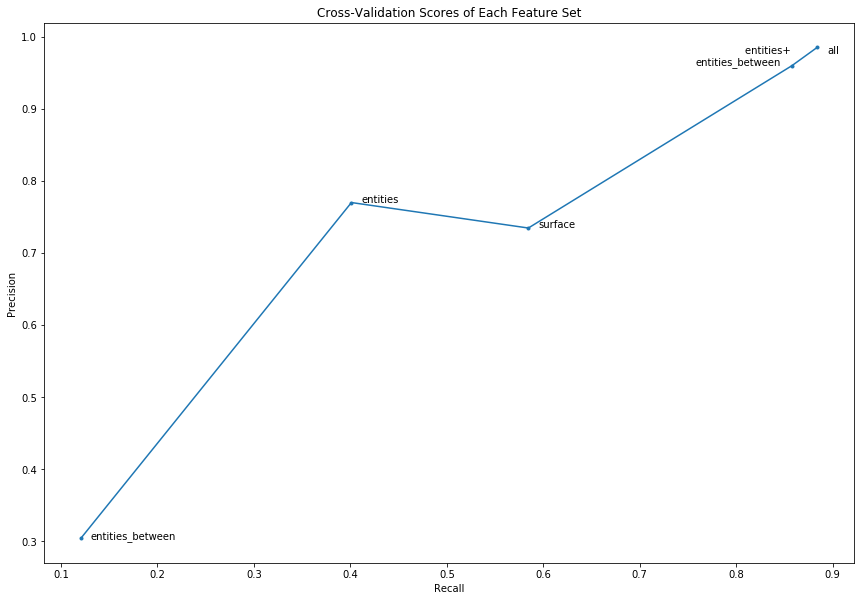

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline
# First, sort the metrics
items = sorted(metrics.items(), key=lambda x:x[1]['f1'], reverse=False)

names, scores = zip(*items)
x = [m['recall'] for m in scores]
y = [m['precision'] for m in scores]
z = [m['f1'] for m in scores]
pts = []
print(x)
print(y)
fig, ax = plt.subplots()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Cross-Validation Scores of Each Feature Set')
ax.plot(x, y,marker='.')
fig.subplots_adjust(right=2.0, top=2.0)
for i, txt in enumerate(names):
    delta = 0
    
    if '+' in txt:
        txt =   " "*16 + "+\n".join(txt.split('+'))
        delta_x = -0.1
        delta_y = 0
    else:
        delta_x = 0.01
        delta_y = 0
    if i == len(names) -1:
        txt = 'all'
        delta_x = 0.01
        delta_y = -0.009
        
    ax.annotate("{0}".format(txt), (x[i] + delta_x, y[i] + delta_y))

In [111]:
import pandas as pd

In [124]:
df = pd.DataFrame.from_dict(metrics, ).transpose()
df = df[['precision', 'recall', 'f1']]
df = df.sort_values(by='f1', ascending=False)
df.head()

,precision,recall,f1
entities+entities_between+surface,0.985088,0.884049,0.931838
entities+entities_between,0.959673,0.857781,0.905871
surface,0.734520,0.584524,0.650993
entities,0.769855,0.401079,0.527396
entities_between,0.304286,0.120591,0.172729


In [125]:
df

,precision,recall,f1
entities+entities_between+surface,0.985088,0.884049,0.931838
entities+entities_between,0.959673,0.857781,0.905871
surface,0.734520,0.584524,0.650993
entities,0.769855,0.401079,0.527396
entities_between,0.304286,0.120591,0.172729
